<a href="https://colab.research.google.com/github/Mrmesmerized/Toxic-Word-Detection-Project/blob/main/notebooks/Toxic_Word_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

### Toxic Word Detection Project

**Objective**:  
Classifying tweets into categories such as "Hate Speech Detected," "Offensive Language Detected," and "No Hate and Offensive Speech.

**Data Acquisition**

In [ ]:
# Install gdown to download files from Google Drive
!pip install gdown

# Download the dataset from Google Drive using the file ID
import gdown

file_id = '1RbAtx5t7x7Com2sjEG6bLrXYJy3LI0vA'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'twitter_data.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1RbAtx5t7x7Com2sjEG6bLrXYJy3LI0vA
To: /content/twitter_data.csv
100%|██████████| 2.55M/2.55M [00:00<00:00, 21.1MB/s]


'twitter_data.csv'

# **Environmental Setup**

**Installing Required Libraries**

In [ ]:
pip install scikit-optimize


**Importing Libraries**

In [ ]:
# Import essential libraries and modules for data handling, machine learning, and plotting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from itertools import cycle
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# **Data Preprocessing**

**Loading the dataset**

In [ ]:
# Load the dataset into a pandas DataFrame and display the first few rows.

df = pd.read_csv('twitter_data.csv')

# Display the first few rows of the dataset
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# Ensure nltk is installed correctly
try:
    from nltk.corpus import stopwords
except ImportError as e:
    print(f"Error importing nltk: {e}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    from nltk.corpus import stopwords

# Initialize nltk
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer('english')
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Data Cleaning**

In [ ]:
# Define a function to clean the text data by removing unwanted characters, stopwords, etc.
# Apply the cleaning function to the dataset.

# Clean text data function
def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = [word for word in text.split() if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split()]
    text = " ".join(text)
    return text

# Apply cleaning function to the tweets
df["tweet"] = df["tweet"].apply(clean)

# Drop rows with missing values in 'tweet' or 'class'
df = df.dropna(subset=['tweet', 'class'])


# **Data Exploration**

Class distribution before SMOTE:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


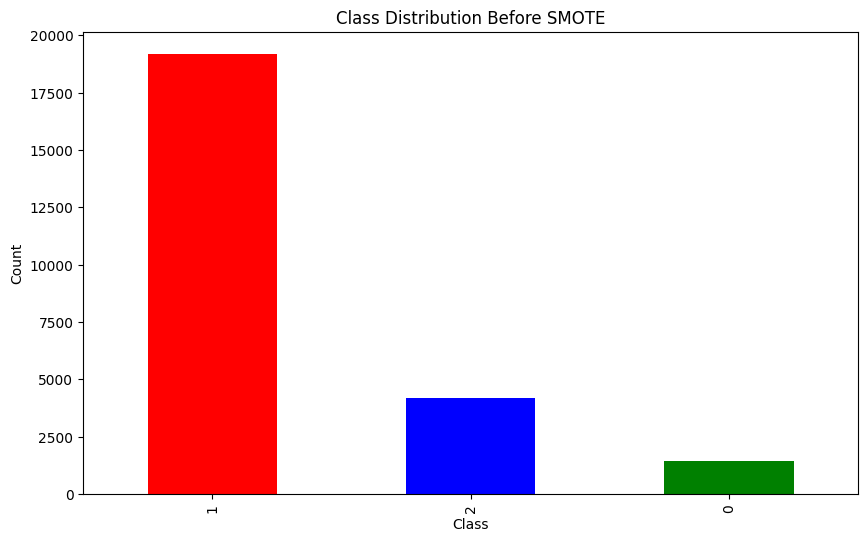

In [ ]:
# Print the class distribution count
class_distribution = df['class'].value_counts()
print("Class distribution before SMOTE:")
print(class_distribution)

# Plot the class distribution before SMOTE
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('class_distribution_before.svg', bbox_inches='tight')
plt.show()

# **Feature Engineering**

**Vectorization**

In [ ]:
# Prepare data for model training
x = np.array(df["tweet"])
y = np.array(df["class"])
cv = CountVectorizer()
x_cv = cv.fit_transform(x)


In [ ]:
# Print the TF-IDF result
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(x)
print("TF-IDF result shape:", X_tfidf.shape)
print("TF-IDF feature names:", tfidf.get_feature_names_out()[:10])  # Print first 10 feature names

TF-IDF result shape: (24783, 25302)
TF-IDF feature names: ['aa' 'aaaaaaaaand' 'aaahhhhh' 'aahahah' 'aaliyah' 'aaliyahhhm'
 'aaliyahhlove' 'aamaadmiparti' 'aampt' 'aamu']


**Train-Test Split**

In [ ]:
# Train-test split on the data
X_train, X_test, y_train, y_test = train_test_split(x_cv, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


**Handling Missing Values**

In [ ]:
# Check for NaN values in X_train and X_test
print(f"NaN values in X_train: {np.isnan(X_train.toarray()).sum()}")
print(f"NaN values in X_test: {np.isnan(X_test.toarray()).sum()}")

NaN values in X_train: 0
NaN values in X_test: 0


# **Handling Imbalance**

**Applying SMOTE**

In [ ]:
# Use SMOTE to balance the training dataset.

# Print the new class distribution count after applying SMOTE
new_class_distribution = pd.Series(y_train_resampled).value_counts()
print("Class distribution after SMOTE:")
print(new_class_distribution)

Class distribution after SMOTE:
0    15358
2    15358
1    15358
Name: count, dtype: int64


**Post-SMOTE Class Distribution**

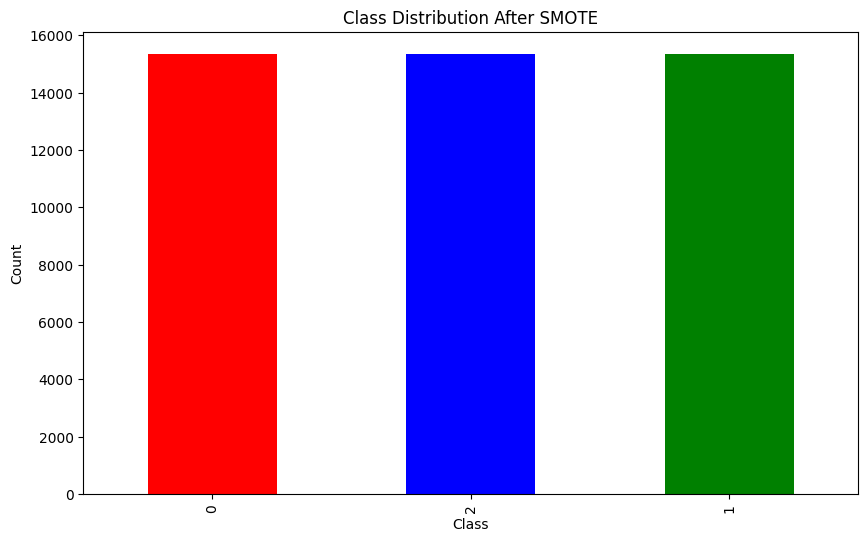

In [ ]:
# Display and plot the class distribution after applying SMOTE

# Plot the class distribution after SMOTE
plt.figure(figsize=(10, 6))
new_class_distribution.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('class_distribution_after.svg', bbox_inches='tight')
plt.show()

# **Model Training**

**Defining the Hyperparameters**

In [ ]:
# Define the hyperparameters to tune using Bayesian Optimization
param_space = {
    "criterion": Categorical(["gini", "entropy"]),  # Splitting criterion
    "max_depth": Integer(1, 20),  # Maximum depth of the tree
    "min_samples_split": Integer(2, 20),  # Minimum number of samples required to split an internal node
    "min_samples_leaf": Integer(1, 20),  # Minimum number of samples required to be at a leaf node
    "max_features": Categorical(["sqrt", "log2", None])  # Number of features to consider when looking for the best split
}


**Decision Tree Classifier**

In [ ]:
# Instantiate the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

**Bayesian Hyperparameter Tuning**

In [ ]:
# Use BayesSearchCV for hyperparameter tuning
bayes_search = BayesSearchCV(clf, param_space, n_iter=32, cv=5, verbose=1, n_jobs=-1, random_state=42)
bayes_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
              n_iter=32, n_jobs=-1, random_state=42,
              search_spaces={'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'min_samples_leaf': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize')},
              verbose=1)

In [ ]:
# Print the best parameters found
print(f"Best parameters found: {bayes_search.best_params_}")

Best parameters found: OrderedDict([('criterion', 'entropy'), ('max_depth', 20), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 20)])


In [ ]:
# Use Bayesian Optimization to find the best hyperparameters for the Decision Tree model.

# Train the classifier with the best parameters
best_clf = bayes_search.best_estimator_
best_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_optimized = best_clf.predict(X_test)


# **Model Evaluation**

**Confusion Matrix**

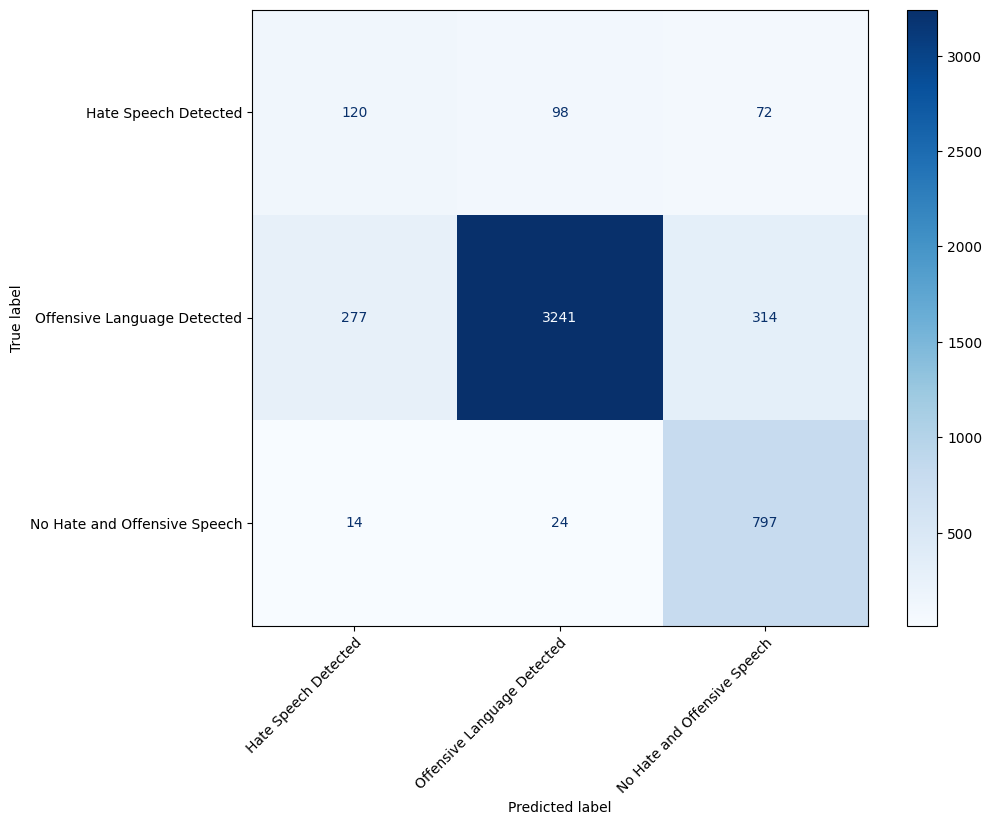

In [ ]:
# Generate the confusion matrix for the optimized model
cm_optimized = confusion_matrix(y_test, y_pred_optimized, labels=[0, 1, 2])

# Display the confusion matrix with adjusted font sizes
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_optimized, display_labels=['Hate Speech Detected', 'Offensive Language Detected', 'No Hate and Offensive Speech'])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.savefig('optimized_confusion_matrix.svg', bbox_inches='tight')
plt.show()


**classification Report**

In [ ]:
# Print a detailed classification report

# Classification report for the optimized model
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=['Hate Speech Detected', 'Offensive Language Detected', 'No Hate and Offensive Speech']))

Optimized Classification Report:
                              precision    recall  f1-score   support

        Hate Speech Detected       0.29      0.41      0.34       290
 Offensive Language Detected       0.96      0.85      0.90      3832
No Hate and Offensive Speech       0.67      0.95      0.79       835

                    accuracy                           0.84      4957
                   macro avg       0.64      0.74      0.68      4957
                weighted avg       0.88      0.84      0.85      4957



**ROC and Precision-Recall Curves**

In [ ]:
# Get the predicted probabilities for the optimized model
y_score_optimized = best_clf.predict_proba(X_test)

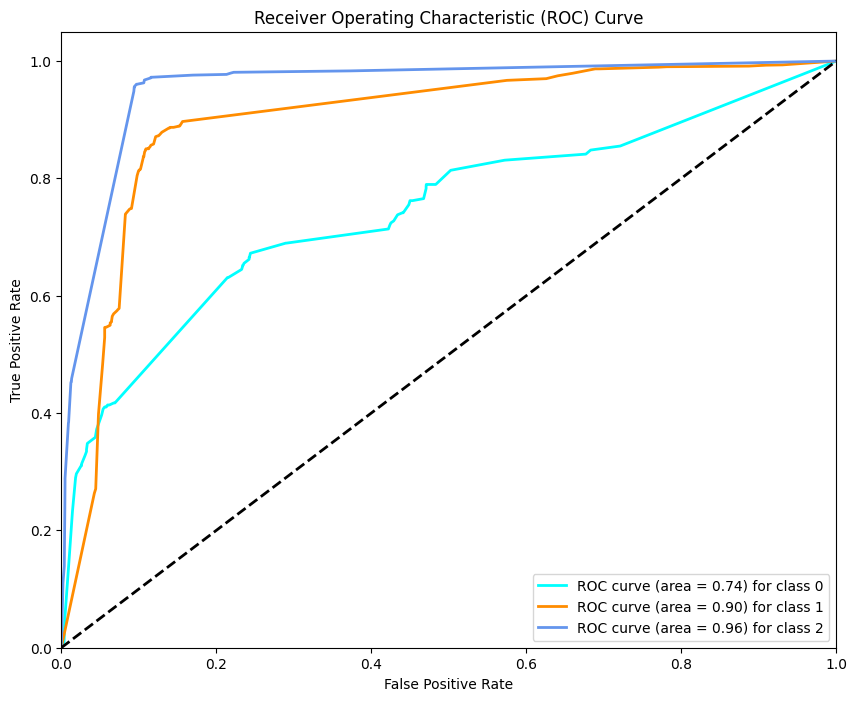

In [ ]:
# Binarize the output for ROC and Precision-Recall curve generation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Generate ROC and Precision-Recall curves for each class
fpr, tpr, roc_auc = dict(), dict(), dict()
precision, recall, average_precision = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_optimized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score_optimized[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score_optimized[:, i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.svg', bbox_inches='tight')
plt.show()


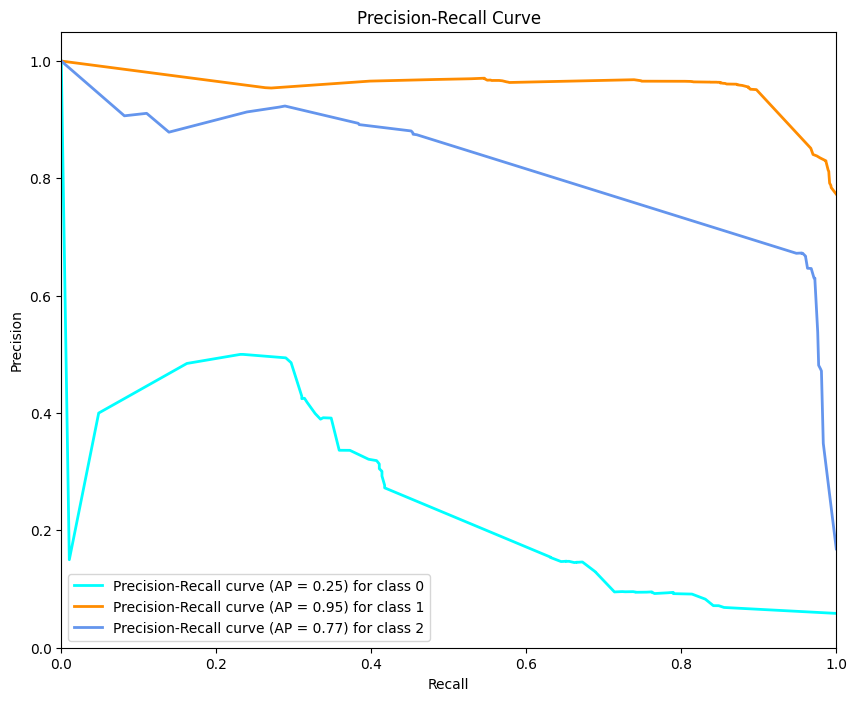

In [ ]:
# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Precision-Recall curve (AP = {average_precision[i]:0.2f}) for class {i}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('precision_recall_curve.svg', bbox_inches='tight')
plt.show()